# Exploration 16. Movie_Prediction
>  프로젝트 소개: 영화 시청 데이터를 기반으로 시청할 영화 예측하기

***

# 프로젝트 목표
   * 세션과 GRU모델에 대한 이해  
   * precision@k, recall@k, MAP, MRR, NDCG 지표에 대한 이해  
   * 데이터를 이해하고 분리해서 학습, 예측하기

***

# 프로젝트 순서
## 1. 데이터 불러오기 & 살펴보기
## 2. 데이터 전처리
## 3. 미니 배치의 구성
## 4. 모델 구성
## 5. 모델 학습
## 6. 모델 리스트
## 7. 하이퍼 파라미터 변경에 따른 지표 변화
## 8. 회고
- 8-1. 루브릭 평가  
- 8-2. 회고

***

# 1. 데이터 불러오기 & 살펴보기

In [1]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

1) wget으로 데이터 다운로드  
$ wget http://files.grouplens.org/datasets/movielens/ml-1m.zip  

2) 다운받은 데이터를 작업디렉토리로 이동  
$ mv ml-1m.zip ~/aiffel/yoochoose-data  

3) 압축 해제  
$ cd ~/aiffel/yoochoose-data && unzip ml-1m.zip

In [82]:
# 경로 설정
data_path = Path(os.getcwd() +'/yoochoose-data/ml-1m') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'MovieId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,MovieId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


### 유저 수 확인하기
- 유니크한 유저 수 = 6040명

In [83]:
data['UserId'].nunique()

6040

### 영화 수 확인하기
- 유니크한 영화 수 = 3706개

In [84]:
data['MovieId'].nunique()

3706

### UserId를 기준으로 Time순으로 정렬

In [85]:
data.sort_values(['UserId','Time'], inplace=True)
data

,UserId,MovieId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


# 2. 데이터 전처리

### Session Length

In [86]:
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [87]:
session_length.median(), session_length.mean()

(96.0, 165.5975165562914)

In [88]:
session_length.min(), session_length.max()

(20, 2314)

In [89]:
session_length.quantile(0.999)

1343.181000000005

각 세션의 길이는 보통 165이며, 99.9% 세션은 길이가 1343이하입니다.  
**하지만 한 사람이 시청했다고 하기엔 1343은 큰 것 같습니다.**  
### 길이가 2314인 데이터를 짚고 넘어가자.

In [90]:
long_session = session_length[session_length==session_length.max()].index[0]
data[data['UserId']==long_session]

,UserId,MovieId,Rating,Time
696969,4169,1268,5,965333392
697168,4169,2617,4,965333392
697185,4169,2628,4,965333392
697219,4169,2653,4,965333392
697275,4169,423,3,965333392
...,...,...,...,...
697882,4169,3754,2,1024174347
695702,4169,1413,3,1024175031
697358,4169,494,4,1024175760
695945,4169,1804,2,1024175783


위에서 알 수 있듯 `Time`컬럼에서 965333392값이 반복되는 것 같다.  
**실제로 965333392 이란 값이 얼마나 있는지 알아보자.**  
### 동일한 시간동안 5개의 영화를 시청했다는 다소 의아한 결과이다.
#### 먼저 `UserId`가 4169의 `Time`이 중복된 데이터 확인 = 1630개!
- 무려 1630개가 중복이다.

In [91]:
long_session_df = data[data['UserId']==long_session]

long_session_df[long_session_df[long_session_df['UserId']==4169].duplicated(['Time'], keep=False)]

,UserId,MovieId,Rating,Time
696969,4169,1268,5,965333392
697168,4169,2617,4,965333392
697185,4169,2628,4,965333392
697219,4169,2653,4,965333392
697275,4169,423,3,965333392
...,...,...,...,...
696404,4169,3126,4,1000082568
697098,4169,3229,4,1000082568
697120,4169,2299,3,1000082568
696000,4169,2486,2,1006744375


### 전체 데이터에 대해서 Time이 중복인 경우 확인

In [92]:
# duplicated라는 새로운 컬럼을 만든다. 컬럼 내용은 일단 데이터 전체에 대한 중복검사를 한다.
# keep=False를 사용하면 중복된 모든 데이터에 대해 True로 변환
# keep='first'는 중복된 데이터 중 첫 번째는 제외하고 나머지 중복 데이터에 대해 True로 변환
# keep='last'는 중복된 데이터 중 마지막은 제외하고 나머지 중복 데이터에 대해 True로 변환

data['duplicated'] = data.duplicated(keep=False)
data

,UserId,MovieId,Rating,Time,duplicated
31,1,3186,4,978300019,False
22,1,1270,5,978300055,False
27,1,1721,4,978300055,False
37,1,1022,5,978300055,False
24,1,2340,3,978300103,False
...,...,...,...,...,...
1000019,6040,2917,4,997454429,False
999988,6040,1921,4,997454464,False
1000172,6040,1784,3,997454464,False
1000167,6040,161,3,997454486,False


### `duplicated`컬럼에 `UserId`기준으로 `Time` 컬럼 값이 중복인 데이터데 대해 True로 변환
- `duplicated`컬럼을 보면 True로 변환된 값을 확인할 수 있다.  
[참고 링크1](https://blog.naver.com/PostView.nhn?blogId=nackji80&logNo=221660411854&categoryNo=53&parentCategoryNo=0&viewDate=&currentPage=1&postListTopCurrentPage=1&from=postView)  
[참고 링크2](https://stackoverflow.com/questions/46217510/better-way-to-identify-duplicates-in-a-group-in-a-pandas-dataframe)

In [93]:
# subset을 이용해 UserId, Time 컬럼에 대해 중복된 값을 모두 True로 표현
# 만약 keep부분에 'first', 'last' 사용가능 하며 기능은 윗 셀에서 설명함

data['duplicated'] = data.duplicated(subset=['UserId', 'Time'], keep=False)
data

,UserId,MovieId,Rating,Time,duplicated
31,1,3186,4,978300019,False
22,1,1270,5,978300055,True
27,1,1721,4,978300055,True
37,1,1022,5,978300055,True
24,1,2340,3,978300103,False
...,...,...,...,...,...
1000019,6040,2917,4,997454429,False
999988,6040,1921,4,997454464,True
1000172,6040,1784,3,997454464,True
1000167,6040,161,3,997454486,False


### `UserId`가 1인 사람의 `Time`중복 데이터 확인해보기
- 총 31개  
- Time 별로 중복된 값을 확인할 수 있다.

In [94]:
user_1_duplicated = data[data['duplicated']==True][data[data['duplicated']==True]['UserId'] == 1]
user_1_duplicated

,UserId,MovieId,Rating,Time,duplicated
22,1,1270,5,978300055,True
27,1,1721,4,978300055,True
37,1,1022,5,978300055,True
7,1,2804,5,978300719,True
47,1,1207,4,978300719,True
0,1,1193,5,978300760,True
21,1,720,3,978300760,True
44,1,260,4,978300760,True
14,1,1035,5,978301753,True
42,1,1962,4,978301753,True


### 중복된 데이터 개수
- 774,028개

In [95]:
data[data['duplicated']==True].shape[0]

774028

In [96]:
print('중복되는 데이터의 비율: %6.2f'%(774028 / 1000209 * 100),'%')

중복되는 데이터의 비율:  77.39 %


### 중복 데이터에 대한 고찰
- 77% 이상이라면..단순히 제거하기엔 너무 크다.  

**온라인에서 시청하는만큼 동일 UserId를 여러 명이 동시에 사용할수도 있겠다는 생각이 들었다. 마치 `NetFilx`를 이용할 때 여러 사람이 하나의 ID를 이용하는 것과 같다.**  
![netfilx](pics/netfilx.png)
![netfilx_id_sharing](pics/netfilx_1.png)

### 그럼 시간대를 실제로 보고 어떤지 확인해보자
- datetime 모듈을 이용  
- 중복된 데이터 하나를 살펴보면 **2000년 12월 31**일이다.  
- 넷플릭스는 **1998년에 세계최초 온라인 영화 서비스를 시작**했다고 하니 납득이 가는 부분이다.  
[넷플릿스 서비스 시작일](https://ko.wikipedia.org/wiki/%EB%84%B7%ED%94%8C%EB%A6%AD%EC%8A%A4)  

#### datetime 모듈 이용 관련 블로그
[블로그1](https://itholic.github.io/python-datetime-calculate/)  
[블로그2](https://www.delftstack.com/ko/howto/python/python-datetime-subtraction/)

In [97]:
# UserId == 1인 사용자의 중복 데이터 데이터프레임 중 하나
user_1_duplicated['Time'][0]

978300760

### 영화를 시청한 시간 구하는 함수

In [98]:
def transfer_time(seconds):
    standard_time = datetime.datetime(1970,1,1,0,0,0)
    
    time = standard_time + datetime.timedelta(seconds=seconds)
    return time

In [99]:
# User 1의 중복 영화 중 하나를 시청한 시간 = 2000-12-31 22:12:40

import datetime

standard_time = datetime.datetime(1970,1,1,0,0,0)
print('기준시간: ',standard_time)

first_date_sec = int(user_1_duplicated['Time'][0])
first_date = transfer_time(first_date_sec)
print('User 1의 중복 영화 중 하나를 시청한 시간: ',first_date)

기준시간:  1970-01-01 00:00:00
User 1의 중복 영화 중 하나를 시청한 시간:  2000-12-31 22:12:40


In [100]:
# User 1의 다른 영화를 본 시간대 = 2001-01-06 23:38:11

last_date_sec = int(user_1_duplicated['Time'][30])
last_date = transfer_time(last_date_sec)
print('User 1의 중복 영화 중 하나를 시청한 시간: ',last_date)

User 1의 중복 영화 중 하나를 시청한 시간:  2001-01-06 23:38:11


### ~`duplicated` 열이 `True`인 row 삭제~

In [101]:
# data = data.drop(data[data['duplicated'] == True].index)
# data

### `duplicated` 열 삭제

In [102]:
data = data.drop(['duplicated'], axis=1)
data.head(5)

,UserId,MovieId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103


### 세션길이 기준 하위 99.9%까지의 분포 누적합을 시각화

In [103]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

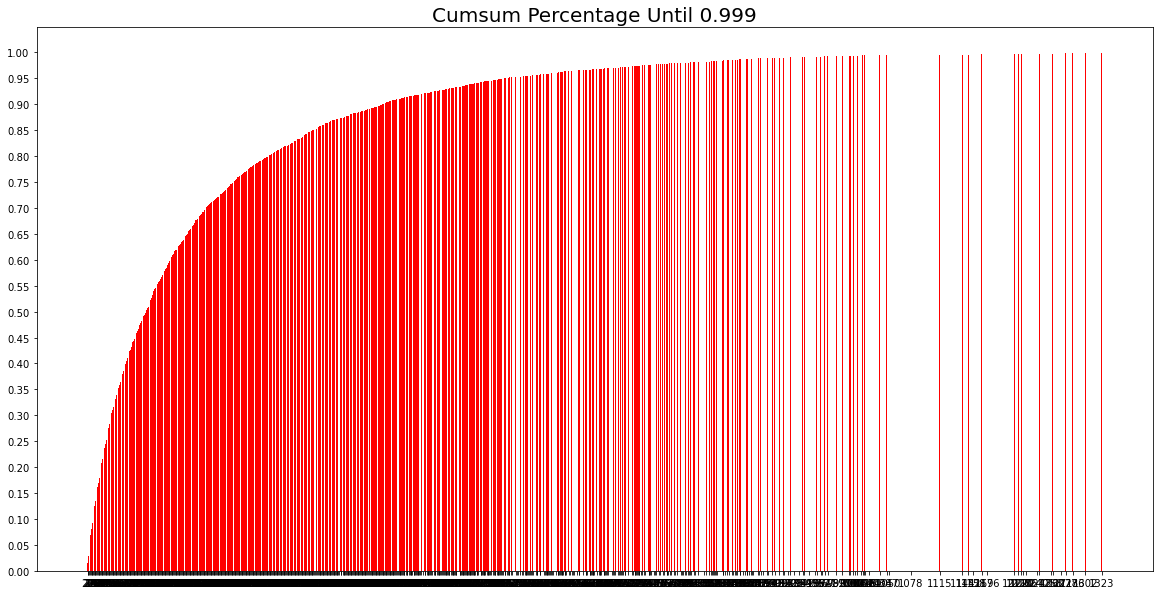

In [104]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

### Session Time

In [105]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest)
print(latest)
print('\n')
oldest_time = transfer_time(oldest)
latest_time = transfer_time(latest)
print(oldest_time)
print(latest_time)

956703932
1046454590


2000-04-25 23:05:32
2003-02-28 17:49:50


\>> 약 3년 간의 데이터가 들어있다. 다면 여기서는 사용자별로 각기 다른 시간 데이터를 가지고 있다.

### ~Data Cleansing~
- 각 개인이 가지고 있는 데이터 개수 확인해보기  

**\>> 최소 20개 이상 가지고 있음. 적은 데이터 수를 가지고 있는 `UserId`없음**

In [106]:
# 데이터를 19개 이하로 가지고 있는 사용자 없음
user_size = data.groupby(['UserId']).size() <= 19
user_size[user_size == True]

Series([], dtype: bool)

In [107]:
# 데이터를 20개 이하로 가지고 있는 사용자 있음 (최소 20개는 가지고 있음)
user_size = data.groupby(['UserId']).size() <= 20
user_size[user_size == True]

UserId
98      True
160     True
217     True
250     True
311     True
        ... 
5533    True
5725    True
5828    True
5904    True
6038    True
Length: 86, dtype: bool

### 시간 변환 컬럼 추가

In [108]:
time_list = []
for i in range(data.shape[0]):
    time_list.append(transfer_time(int(data['Time'][i])))

data['Time_transfer'] = time_list
data.head(5)

,UserId,MovieId,Rating,Time,Time_transfer
31,1,3186,4,978300019,2000-12-31 22:12:40
22,1,1270,5,978300055,2000-12-31 22:35:09
27,1,1721,4,978300055,2000-12-31 22:32:48
37,1,1022,5,978300055,2000-12-31 22:04:35
24,1,2340,3,978300103,2001-01-06 23:38:11


In [109]:
data.reset_index(drop=True, inplace=True)
data.head(5)

,UserId,MovieId,Rating,Time,Time_transfer
0,1,3186,4,978300019,2000-12-31 22:12:40
1,1,1270,5,978300055,2000-12-31 22:35:09
2,1,1721,4,978300055,2000-12-31 22:32:48
3,1,1022,5,978300055,2000-12-31 22:04:35
4,1,2340,3,978300103,2001-01-06 23:38:11


***

# 3. 미니 배치의 구성

### Train/Valid/Test Split
- 총 시간 구간은 약 3년이므로 아래와 같이 기간을 설정한다.  
1) train: 최초 ~ 마지막 2달 전  
2) valid: 마지막 시기로부터 2달 전 (총 1달)  
3) test:  마지막 한 달

In [110]:
# Time_transfer 컬럼 기준으로 데이터를 나눈다.
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time_transfer'].max()
    session_last_time = data.groupby('UserId')['Time_transfer'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(days=n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index
    
    before_date = data[data['UserId'].isin(session_in_train)]
    after_date = data[data['UserId'].isin(session_in_test)]
    after_date = after_date[after_date['MovieId'].isin(before_date['MovieId'])]
    return before_date, after_date

In [158]:
tr, test = split_by_date(data, n_days=30)
tr, val = split_by_date(tr, n_days=30)

In [159]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["MovieId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [160]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 919748
	 Sessions: 5858
	 Items: 3693
	 First Time : 956703932
	 Last Time : 1041215174

* valid Set Stats Info
	 Events: 29494
	 Sessions: 79
	 Items: 2977
	 First Time : 957547221
	 Last Time : 1043809240

* test Set Stats Info
	 Events: 50952
	 Sessions: 103
	 Items: 3198
	 First Time : 957179713
	 Last Time : 1046454590



In [161]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['MovieId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['MovieId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

### ❗코드 파헤치기 - 딕셔너리.get(x,y)
- 딕셔너리.get(x,y): x라는 키(key)가 있으면 x에 해당하는 값(value)을 보여주고, 없다면 y를 보여줘라.  
예시: dict = {'a' : 1, 'b' : 2}  
dict.get('a') # 1  
dict.get('x','y') # 'y'

### Data Pipeline

In [162]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

### Session Dataset
- 데이터가 주어지면 세션이 시작되는 인덱스를 담는 값과 세션을 새로 인덱싱한 값을 갖는 클래스를 만듭니다.

In [163]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to UserId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

train데이터로 `SessionDataset` 객체를 만들고 인스턴스 변수들을 살펴보겠습니다.  
`click_offsets`: 각 세션이 시작된 인덱스  
`session_idx`: 각 세션을 인덱싱한 `np.array`  

In [164]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,MovieId,Rating,Time,Time_transfer,item_idx
0,1,3186,4,978300019,2000-12-31 22:12:40,0
1,1,1270,5,978300055,2000-12-31 22:35:09,1
2,1,1721,4,978300055,2000-12-31 22:32:48,2
3,1,1022,5,978300055,2000-12-31 22:04:35,3
4,1,2340,3,978300103,2001-01-06 23:38:11,4
5,1,1836,5,978300172,2000-12-31 22:37:48,5
6,1,3408,4,978300275,2000-12-31 22:33:59,6
7,1,2804,5,978300719,2000-12-31 22:11:59,7
8,1,1207,4,978300719,2000-12-31 22:37:48,8
9,1,1193,5,978300760,2000-12-31 22:22:48,9


In [165]:
tr_dataset.click_offsets

array([     0,     53,    182, ..., 919284, 919407, 919748], dtype=int32)

In [166]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 5855, 5856, 5857])

### Session Data Loader
파이썬 문법 중 iterator, generator에 대한 좀더 친절한 안내가 필요하신 분은 이 [자료](https://dojang.io/mod/page/view.php?id=2405)를 먼저 보시길 권장합니다.  

`SessionDataset` 객체를 받아서 Session-Parallel mini-batch를 만드는 클래스를 만듭니다.
`__iter__` 메소드는 모델 인풋, 라벨, 세션이 끝나는 곳의 위치를 `yield`합니다.
mask는 후에 RNN Cell State를 초기화 하는데 사용할 것입니다.

In [167]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [168]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,MovieId,Rating,Time,Time_transfer,item_idx
0,1,3186,4,978300019,2000-12-31 22:12:40,0
1,1,1270,5,978300055,2000-12-31 22:35:09,1
2,1,1721,4,978300055,2000-12-31 22:32:48,2
3,1,1022,5,978300055,2000-12-31 22:04:35,3
4,1,2340,3,978300103,2001-01-06 23:38:11,4
5,1,1836,5,978300172,2000-12-31 22:37:48,5
6,1,3408,4,978300275,2000-12-31 22:33:59,6
7,1,2804,5,978300719,2000-12-31 22:11:59,7
8,1,1207,4,978300719,2000-12-31 22:37:48,8
9,1,1193,5,978300760,2000-12-31 22:22:48,9


In [169]:
iter_ex = iter(tr_data_loader)

In [170]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 53 65 54]
Label Item Idx are :       [ 1 54 62 24]
Previous Masked Input Idx are []


***

# 4. 모델 구성

In [171]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [172]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [214]:
def create_model_2nd(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

모델에 사용할 hyper-parameter를 class형식으로 관리

In [218]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['MovieId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.3, lr=0.001, epochs=1, k=20)

In [219]:
model = create_model_2nd(args)

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(64, 1, 3693)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      561750    
_________________________________________________________________
dropout_14 (Dropout)         (64, 50)                  0         
_________________________________________________________________
dense_11 (Dense)             (64, 3693)                188343    
Total params: 750,093
Trainable params: 750,093
Non-trainable params: 0
_________________________________________________________________


***

### 모델 평가 지표

모델 성능 평가를 위한 지표를 보겠습니다.  
모델 성능에 대한 지표로 precision이나 recall이 있습니다.  
Session-Based Recommendation Task에서는 모델이 k개의 아이템을 제시했을 때, 유저가 클릭/ 구매한 n개의 아이템이 많아야 좋습니다.  
이 때문에 recall의 개념을 확장한 recall@k 지표, precision의 개념을 확장한 Mean Average Precision@k 지표 등을 사용합니다.  
추천에서는 몇 번째로 맞추느냐도 중요합니다. 구글에서 검색했을 때 1페이지에 원하는 결과가 나오지 않고 2페이지에 나온다면 유저 반응이 크게 떨어질 것입니다.  
따라서 순서에 민감한 지표인 MRR, NDCG 같은 지표도 사용합니다.  
이번 자료에서는 MRR과 Recall@k를 사용하겠습니다. MRR은 정답 아이템이 나온 순번의 역수 값입니다.  
따라서 정답 아이템이 추천 결과 앞쪽 순번에 나온다면 지표가 높아질 것이고 뒤쪽에 나오거나 안나온다면 지표가 낮아질 것입니다. 

In [220]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

# 5. 모델 학습

In [221]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [222]:
# 학습 시간이 다소 오래 소요됩니다. (예상시간 1시간)
train_model(model, args)

Evaluation:  29%|██▊       | 131/459 [00:32<01:20,  4.08it/s]

	 - Recall@20 epoch 1: 0.245468
	 - MRR@20    epoch 1: 0.063802



***

# 6. 모델 테스트

In [223]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  53%|█████▎    | 418/794 [01:42<01:32,  4.08it/s]

	 - Recall@20: 0.220918
	 - MRR@20: 0.055921



***

# 7. 하이퍼 파라미터 변경에 따른 지표 변화

### 총 4가지 지표 변화에 대한 결과

1. batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=1, k=20  
- Recall@20: 0.226600  
- MRR@20: 0.058414  

2. batch_size=64, hsz=50, drop_rate=0.3, lr=0.001, epochs=1, k=20  
- Recall@20: 0.222301  
- MRR@20: 0.057714  

3. batch_size=64, hsz=50, drop_rate=0.3, lr=0.001, epochs=10, k=20  
- Recall@20: 0.298146  
- MRR@20: 0.088679  

4. batch_size=64, hsz=50, drop_rate=0.3, lr=0.001, epochs=1, k=20 & 2nd model  
- Recall@20: 0.220918  
- MRR@20: 0.055921


### 지표 변화에 대한 검토
1. drop_rate: 0.1 -> 0.3  
**\>> MRR@20기준: 0.058414 -> 0.057714, 유의미한 결과 없음**  

2. epochs: 1 -> 10  
**\>> MRR@20기준: 0.057714 -> 0.088679, 역시 에폭이 늘어남에 따라 개선 증가 효과 확인**  

3. model변화: GRU, dropout추가  
**\>> MRR@20기준: 0.088679 -> 0.055921, 모델 변경은 오히려 떨어졌다.**

# 8. 회고

## 8-1. 루브릭
### 1. Movielens 데이터셋을 session based recommendation 관점으로 전처리하는 과정이 체계적으로 진행되었다.
데이터셋의 면밀한 분석을 토대로 세션단위 정의 과정(길이분석, 시간분석)을 합리적으로 수행한 과정이 기술되었다.

### 2. RNN 기반의 예측 모델이 정상적으로 구성되어 안정적으로 훈련이 진행되었다.
적절한 epoch만큼의 학습이 진행되는 과정에서 train loss가 안정적으로 감소하고, validation 단계에서의 Recall, MRR이 개선되는 것이 확인된다.

### 3. 세션정의, 모델구조, 하이퍼파라미터 등을 변경해서 실험하여 Recall, MRR 등의 변화추이를 관찰하였다.
3가지 이상의 변화를 시도하고 그 실험결과를 체계적으로 분석하였다.


## 8-2. 회고
1. 추천시스템 두번째 익스, `세션`이라는 새로운 개념에 대해 이해하게 되었다.  
2. 노드에서는 데이터 셋이 2개였는데 본 프로젝트 진행 시에는 하나의 파일로 진행했다.  
3. 데이터 전처리 부분이 중요하다는걸 다시 한번 더 깨달았다. 
4. datetime 모듈을 이용해 실제 날짜와 시간을 구해보니 2000년대임을 알게 되었고 넷플릭스 등 온라인 플랫폼에서 동일한 아이디로 여러 명이 동시에 시청한 기록을 확인 했다.
5. index error가 발생한 숫자보다 배치 사이즈를 더 작게 만들어 학습을 진행하여 에러를 줄였다.